In [1]:
import os
import tensorflow as tf
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
import math

from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import pandas as pd

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [4]:
train_data_dir = r'C:/Users/darks/Desktop/AffectNet/DATASET/AffectNet/train/'
validation_data_dir = r'C:/Users/darks/Desktop/AffectNet/DATASET/AffectNet/test/'

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
num_classes = 7

batch_size=32*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)
class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [6]:
# Init the Image Data Generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train Images
train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
)

# Validation images (From Train Images)
validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'
)

Found 20761 images belonging to 7 classes.
Found 5160 images belonging to 7 classes.


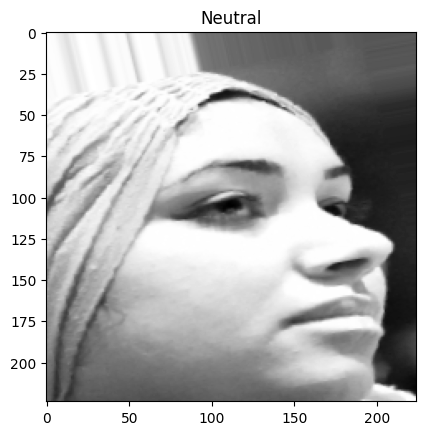

In [7]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [8]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,anger,disgust,fear,happy,neutral,sad,surprise
train,2691,1969,2628,3831,3906,2540,3196
test,662,494,661,960,972,624,787


In [9]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

20761
5160


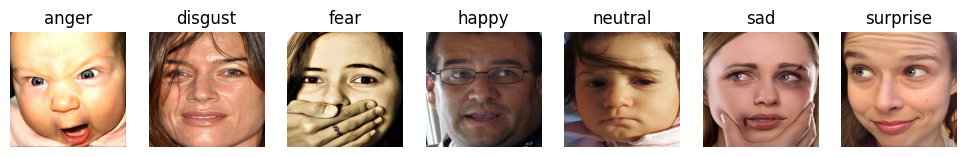

In [10]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# PERFECT CODE

In [11]:
import tensorflow as tf

def basic_block(x, in_channels, out_channels, stride=1):
    expansion = 1
    identity = x

    x = tf.keras.layers.Conv2D(
        out_channels,
        kernel_size=3,
        strides=stride,
        padding='same',
        use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(
        out_channels,
        kernel_size=3,
        strides=1,
        padding='same',
        use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or in_channels != out_channels:
        identity = tf.keras.layers.Conv2D(
            out_channels * expansion,
            kernel_size=1,
            strides=stride,
            use_bias=False)(identity)
        identity = tf.keras.layers.BatchNormalization()(identity)

    x = tf.keras.layers.Add()([x, identity])
    x = tf.keras.layers.ReLU()(x)

    return x

def make_layer(x, block, out_channels, num_blocks, stride):
    x = block(x, x.shape[-1], out_channels, stride)
    for _ in range(1, num_blocks):
        x = block(x, out_channels, out_channels, 1)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(
        64,
        kernel_size=7,
        strides=2,
        padding='same',
        use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    x = make_layer(x, basic_block, 64, 2, 1)
    x = make_layer(x, basic_block, 128, 2, 2)
    x = make_layer(x, basic_block, 256, 2, 2)
    x = make_layer(x, basic_block, 512, 2, 2)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Creating an instance of ResNet18
model = ResNet18()

# Creating dummy input
dummy_input = tf.random.normal((1, 224, 224, 3))

# Checking the output shape
output = model(dummy_input)
print(output.shape)

(1, 7)


In [25]:
# import tensorflow as tf

# def basic_block(x, in_channels, out_channels, stride=1):
#     expansion = 1
#     identity = x
    
#     x = tf.keras.layers.Conv2D(
#         out_channels,
#         kernel_size=3,
#         strides=stride,
#         padding='same',
#         use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
    
#     x = tf.keras.layers.Conv2D(
#         out_channels,
#         kernel_size=3,
#         strides=1,
#         padding='same',
#         use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     if stride != 1 or in_channels != out_channels:
#         identity = tf.keras.layers.Conv2D(
#             out_channels * expansion,
#             kernel_size=1,
#             strides=stride,
#             use_bias=False)(identity)
#         identity = tf.keras.layers.BatchNormalization()(identity)
    
#     x = tf.keras.layers.Add()([x, identity])
#     x = tf.keras.layers.ReLU()(x)
    
#     return x

# def make_layer(x, block, out_channels, num_blocks, stride):
#     x = block(x, x.shape[-1], out_channels, stride)
#     for _ in range(1, num_blocks):
#         x = block(x, out_channels, out_channels, 1)
#     return x

# def ResNet18(input_shape=(48, 48, 3), num_classes=7):
#     inputs = tf.keras.Input(shape=input_shape)
    
#     x = tf.keras.layers.Conv2D(
#         64,
#         kernel_size=3,
#         strides=1,
#         padding='same',
#         use_bias=False)(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
    
#     x = make_layer(x, basic_block, 64, 2, 1)
#     x = make_layer(x, basic_block, 128, 2, 2)
#     x = make_layer(x, basic_block, 256, 2, 2)
#     x = make_layer(x, basic_block, 512, 2, 2)
    
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)


# # #     x = GlobalAveragePooling2D()(x)
# #     x = Dropout(0.5)(x)  # Dropout layer for regularization
# #     x = Dense(512)(x)
# #     x = BatchNormalization()(x)
# #     x = Activation('relu')(x)
# #     x = Dropout(0.5)(x)  # Additional dropout layer

# # #     # Add weight regularization to the dense layers
# #     x = Dense(256)(x)
# #     x = BatchNormalization()(x)
# #     x = Activation('relu')(x)
# #     x = Dropout(0.5)(x)
# #     x = Dense(128)(x)
# #     x = BatchNormalization()(x)
# #     x = Activation('relu')(x)

#     # # Additional improvements
#     x = tf.keras.layers.Dropout(0.5)(x)  # Apply dropout for regularization
#     x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Increase model capacity

#     # x = tf.keras.layers.Dense(4096, activation='relu')(x)  # Increase model capacity
#     x = tf.keras.layers.Dropout(0.5)(x)  # Additional dropout
    
#     outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model

# # Creating an instance of ResNet18
# model = ResNet18()

# # Creating dummy input
# dummy_input = tf.random.normal((1, 48, 48, 3))

# # Checking the output shape
# output = model(dummy_input)
# print(output.shape)

In [12]:
# Open the strategy scope
with strategy.scope():
    model = ResNet18()
    # Compile the model
    model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Save the model architecture diagram as a PNG file
# plot_model(model, to_file='resnet18_architecture.png', show_shapes=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [13]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

# Callbacks

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [14]:
# Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=400,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/400
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = hierarchical_copy, num_packs = 1
324/324 [==============================] - ETA: 0s - loss: 2.5335 - accuracy: 0.2348
Epoch 1: val_accuracy improved from -inf to 0.15176, saving model to best_model.h5
324/324 [==============================] - 283s 825ms/step - loss: 2.5335 - accuracy: 0.2348 - val_loss: 2.3729 - val_accuracy: 0.1518 - lr: 1.0000e-04
Epoch 2/400
324/324 [==============================] - ETA: 0s - loss: 2.1648 - accuracy: 0.3477
Epoch 2: val_accuracy improved from 0.15176 to 0.30527, saving model to best_model.h5
324/324 [==============================] - 259s 797ms/step - loss: 2.1648 - accuracy: 0.3477 - val_loss: 1.7146 - val_accuracy: 0.3053 - lr: 1.0000e-04
Epoch 3/400
324/324 [==============================] - ETA: 0s - loss: 1.8766 - accuracy: 0.4537
Epoch 3: val_accuracy did not improve 

In [15]:
save_model = model.save('RESNET18_Ultimate8.h5')

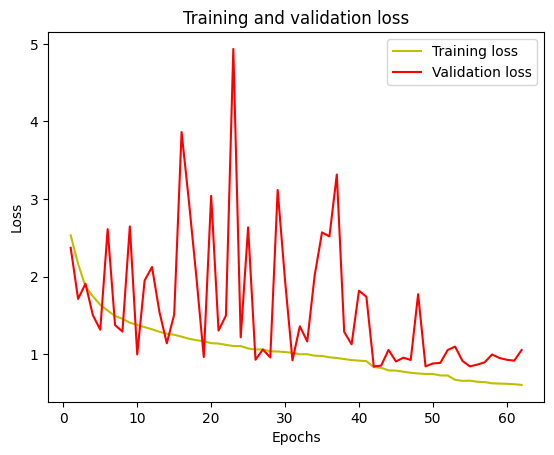

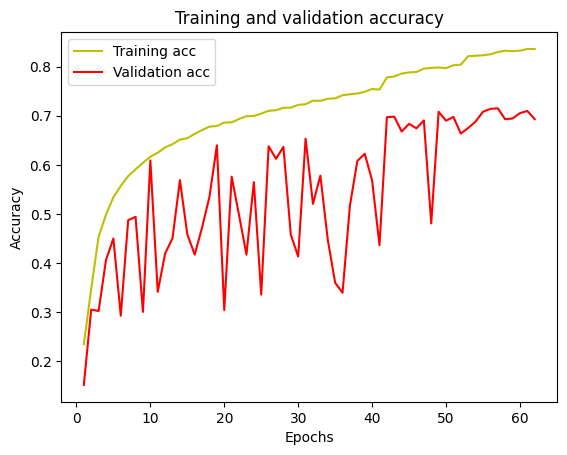

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 2s 152ms/step
Accuracy =  0.59375


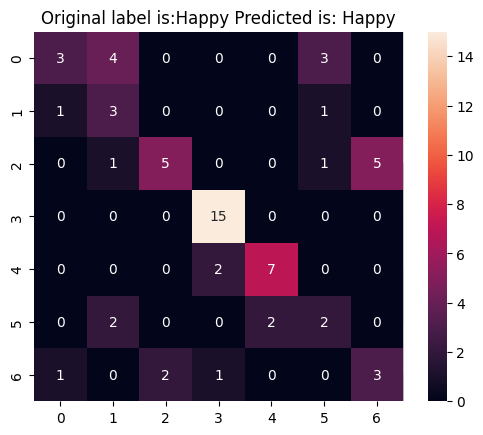

In [17]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Model Evaluation

Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
2/2 [==============================] - 0s 69ms/step
Accuracy =  0.84375


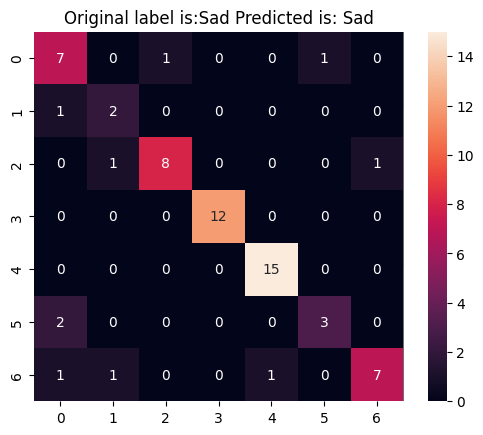

2/2 [==============================] - 0s 69ms/step
Accuracy =  0.578125


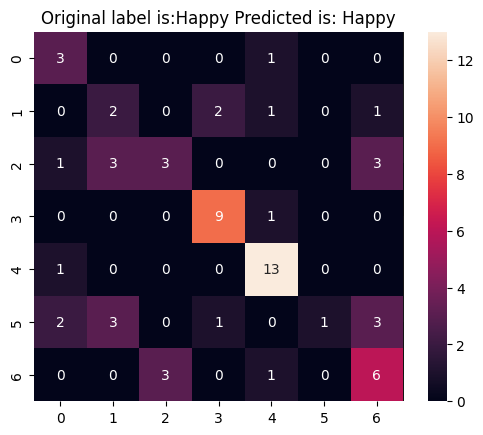

In [18]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [19]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.6914


In [20]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 43ms/step
Accuracy: 69.140625
anger 658/5160 acc: 57.9
disgust 489/5160 acc: 53.0
fear 656/5160 acc: 47.7
happy 953/5160 acc: 89.4
neutral 964/5160 acc: 92.0
sad 619/5160 acc: 49.6
surprise 781/5160 acc: 69.3


In [21]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 69.140625
anger 658/5160 acc: 57.9
disgust 489/5160 acc: 53.0
fear 656/5160 acc: 47.7
happy 953/5160 acc: 89.4
neutral 964/5160 acc: 92.0
sad 619/5160 acc: 49.6
surprise 781/5160 acc: 69.3


              precision    recall  f1-score   support

       anger       0.58      0.58      0.58       658
     disgust       0.56      0.53      0.54       489
        fear       0.64      0.48      0.55       656
       happy       0.91      0.89      0.90       953
     neutral       0.74      0.92      0.82       964
         sad       0.61      0.50      0.55       619
    surprise       0.62      0.69      0.65       781

    accuracy                           0.69      5120
   macro avg       0.67      0.66      0.66      5120
weighted avg       0.69      0.69      0.68      5120



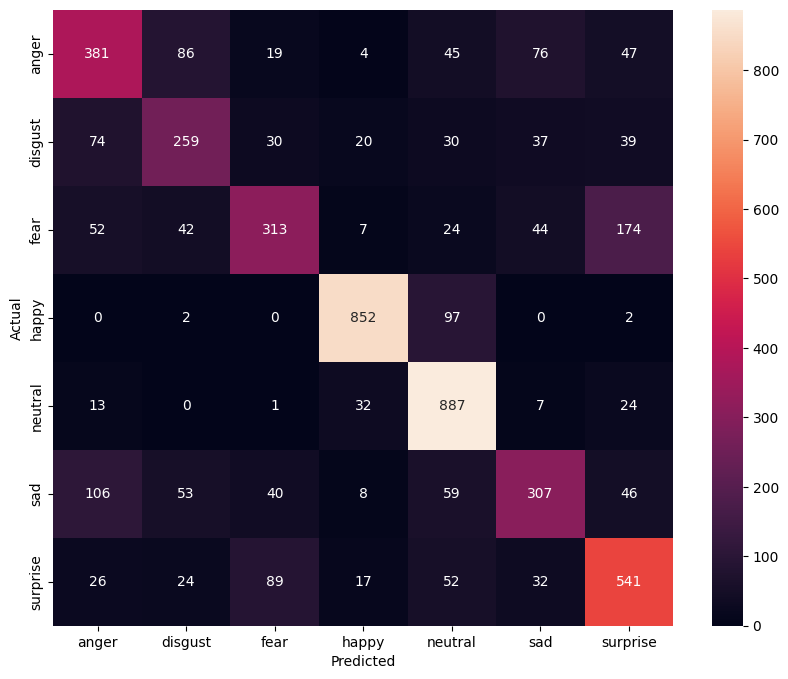

In [22]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(validation_generator)

81/81 [==============================] - 13s 158ms/step - loss: 1.0593 - accuracy: 0.6915


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions for all validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate top 1 accuracy
top1_accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Top 1 Accuracy: {top1_accuracy:.2f}%")

# Calculate top 2 accuracy
top2_predictions = np.argsort(model.predict(test_img), axis=1)[:, -2:]
top2_accuracy = np.mean([1 if true_label in pred_labels else 0 for true_label, pred_labels in zip(y_true, top2_predictions)]) * 100
print(f"Top 2 Accuracy: {top2_accuracy:.2f}%")

# Calculate loss
loss = model.evaluate(test_img, test_lbl)[0]
print(f"Loss: {loss}")

# Calculate precision
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-Score: {f1:.2f}")


2/2 [==============================] - 0s 44ms/step
Top 1 Accuracy: 69.12%
2/2 [==============================] - 0s 73ms/step
Top 2 Accuracy: 32.81%
2/2 [==============================] - 0s 109ms/step - loss: 0.8206 - accuracy: 0.7500
Loss: 0.8206284046173096
Precision: 0.66
Recall: 0.66
F1-Score: 0.66


# Unseen batch

In [25]:
test_data_dir = r'X:/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [26]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


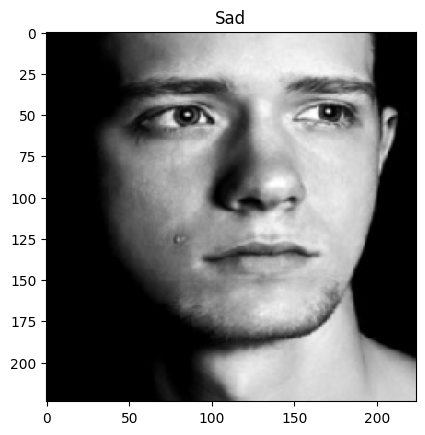

In [27]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
2/2 [==============================] - 0s 78ms/step
Accuracy =  0.71875


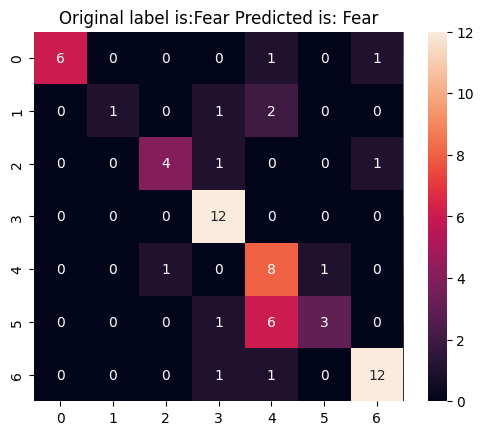

2/2 [==============================] - 0s 119ms/step
Accuracy =  0.40625


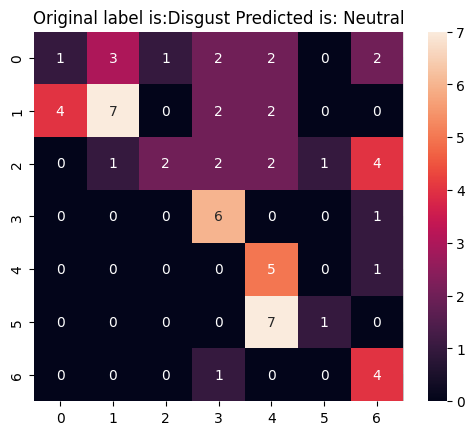

In [28]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [29]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.5557


In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 72ms/step
Accuracy: 55.56640625
Angry 293/2100 acc: 39.9
Disgust 293/2100 acc: 50.2
Fear 293/2100 acc: 26.6
Happy 292/2100 acc: 87.0
Neutral 292/2100 acc: 83.9
Sad 291/2100 acc: 18.9
Surprise 294/2100 acc: 82.3


# Accuracy global and per class

In [31]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 55.56640625
Angry 293/2100 acc: 39.9
Disgust 293/2100 acc: 50.2
Fear 293/2100 acc: 26.6
Happy 292/2100 acc: 87.0
Neutral 292/2100 acc: 83.9
Sad 291/2100 acc: 18.9
Surprise 294/2100 acc: 82.3


              precision    recall  f1-score   support

       Angry       0.65      0.40      0.50       293
     Disgust       0.67      0.50      0.58       293
        Fear       0.74      0.27      0.39       293
       Happy       0.70      0.87      0.78       292
     Neutral       0.37      0.84      0.51       292
         Sad       0.66      0.19      0.29       291
    Surprise       0.56      0.82      0.67       294

    accuracy                           0.56      2048
   macro avg       0.62      0.56      0.53      2048
weighted avg       0.62      0.56      0.53      2048



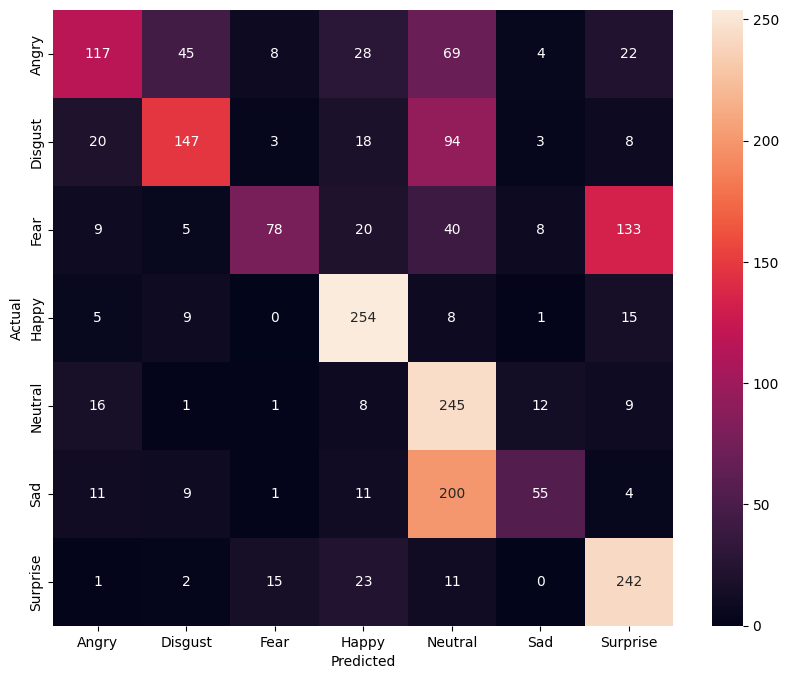

In [32]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with Images

In [35]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('RESNET18_Real_12.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 2s 2s/step
Predicted emotion class: angry, probability: 0.23099695146083832
1/1 [==============================] - 0s 118ms/step
Predicted emotion class: neutral, probability: 0.31965339183807373
1/1 [==============================] - 0s 117ms/step
Predicted emotion class: neutral, probability: 0.3120986521244049
1/1 [==============================] - 0s 104ms/step
Predicted emotion class: neutral, probability: 0.410339891910553
1/1 [==============================] - 0s 115ms/step
Predicted emotion class: neutral, probability: 0.47327131032943726
1/1 [==============================] - 0s 111ms/step
Predicted emotion class: fear, probability: 0.39194685220718384
1/1 [==============================] - 0s 122ms/step
Predicted emotion class: fear, probability: 0.22408470511436462
1/1 [==============================] - 0s 110ms/step
Predicted emotion class: neutral, probability: 0.238662451505661
1/1 [==============================] - 0s 111ms/step
Pre

# Fine Tunning

In [37]:
with strategy.scope():

    model = load_model('best_model.h5')
    
    # # Load the VGG19 model
    # base_model = VGG16(
    #     weights='imagenet', 
    #     include_top=False, 
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    for layer in model.layers:
        layer.trainable = True
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    # inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # x = base_model(inputs)
    # x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x) 
    # predictions = Dense(7, activation='softmax')(x)

    # # Compile the model
    # model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 112, 112, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [38]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [39]:
    # Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=100,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = hierarchical_copy, num_packs = 1
167/167 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.8329
Epoch 1: val_accuracy improved from -inf to 0.76276, saving model to best_model.h5
167/167 [==============================] - 128s 706ms/step - loss: 0.8454 - accuracy: 0.8329 - val_loss: 0.7411 - val_accuracy: 0.7628 - lr: 1.0000e-05
Epoch 2/100
167/167 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.8429
Epoch 2: val_accuracy did not improve from 0.76276
167/167 [==============================] - 110s 656ms/step - loss: 0.8045 - accuracy: 0.8429 - val_loss: 0.7794 - val_accuracy: 0.7535 - lr: 1.0000e-05
Epoch 3/100
167/167 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.8426
Epoch 3: val_accuracy improved from 0.76276 to 0.76540, saving model to b

In [40]:
save_model = model.save('VGG16_VGGFACE_100e_TF_FT_FER.h5')

# Fine Tunning model evaluation

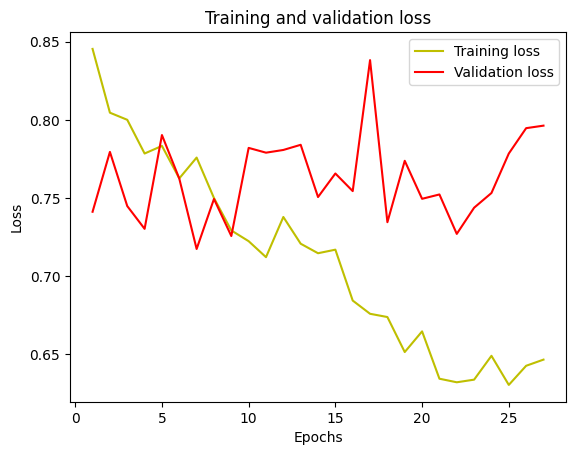

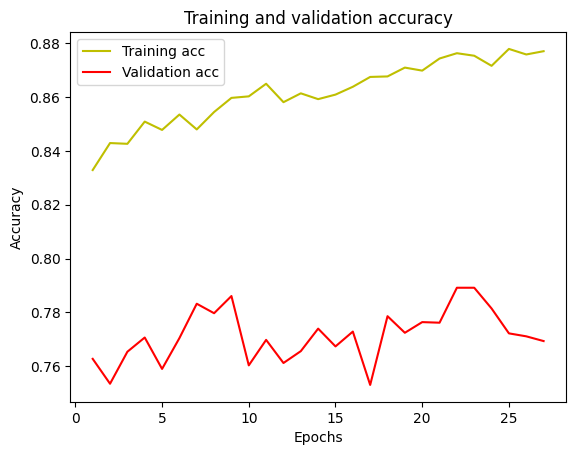

In [41]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = load_model("best_model.h5")

2/2 [==============================] - 2s 133ms/step
Accuracy =  0.765625


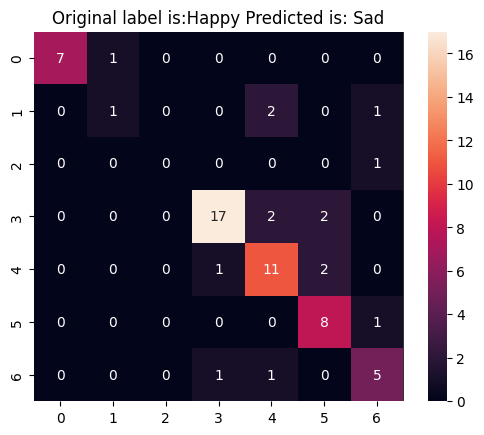

In [42]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 72ms/step
Accuracy =  0.890625


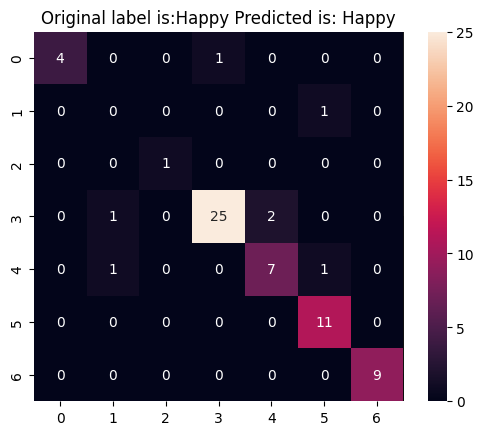

2/2 [==============================] - 0s 64ms/step
Accuracy =  0.59375


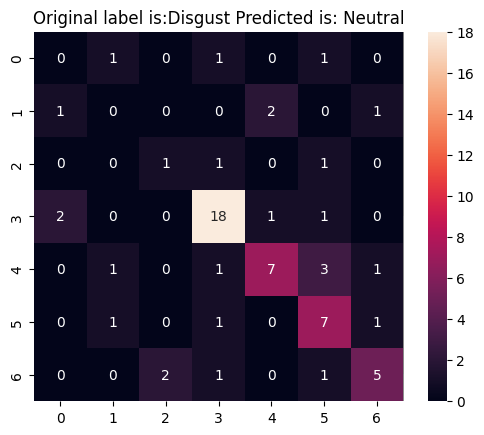

In [43]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [44]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.7691


In [45]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 39ms/step
Accuracy: 76.91461267605634
Angry 257/4606 acc: 68.1
Disgust 260/4606 acc: 51.5
Fear 106/4606 acc: 51.9
Happy 1760/4606 acc: 84.8
Neutral 948/4606 acc: 68.2
Sad 730/4606 acc: 81.1
Surprise 483/4606 acc: 82.6


In [46]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 76.91461267605634
Angry 257/4606 acc: 68.1
Disgust 260/4606 acc: 51.5
Fear 106/4606 acc: 51.9
Happy 1760/4606 acc: 84.8
Neutral 948/4606 acc: 68.2
Sad 730/4606 acc: 81.1
Surprise 483/4606 acc: 82.6


              precision    recall  f1-score   support

       Angry       0.77      0.68      0.72       257
     Disgust       0.47      0.52      0.49       260
        Fear       0.63      0.52      0.57       106
       Happy       0.92      0.85      0.88      1760
     Neutral       0.72      0.68      0.70       948
         Sad       0.63      0.81      0.71       730
    Surprise       0.82      0.83      0.82       483

    accuracy                           0.77      4544
   macro avg       0.71      0.70      0.70      4544
weighted avg       0.78      0.77      0.77      4544



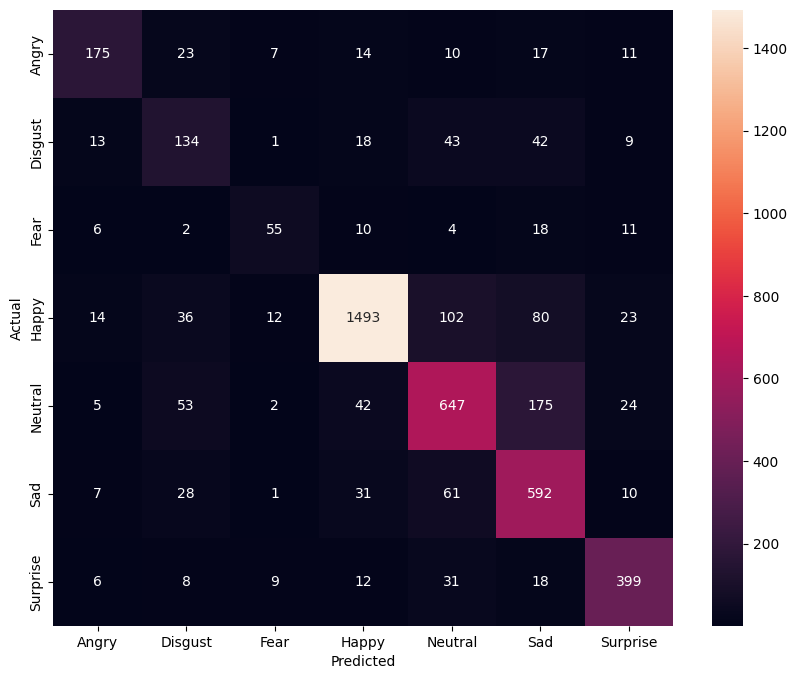

In [47]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [ ]:
model = load_model("VGG16_VGGFACE_100e_TF_FT_FER.h5")

In [48]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [49]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


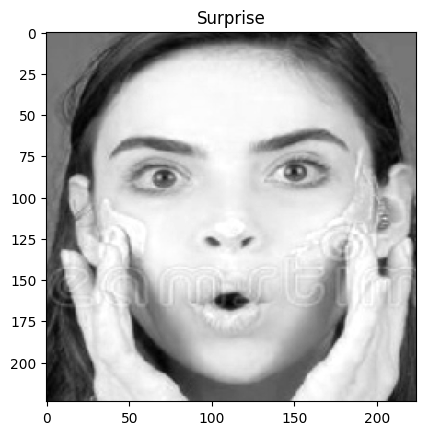

In [50]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 33ms/step
Accuracy =  0.625


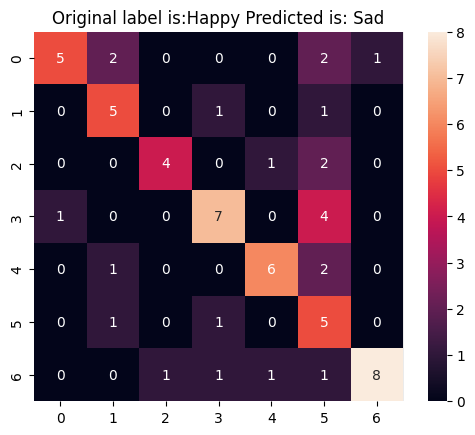

2/2 [==============================] - 0s 37ms/step
Accuracy =  0.375


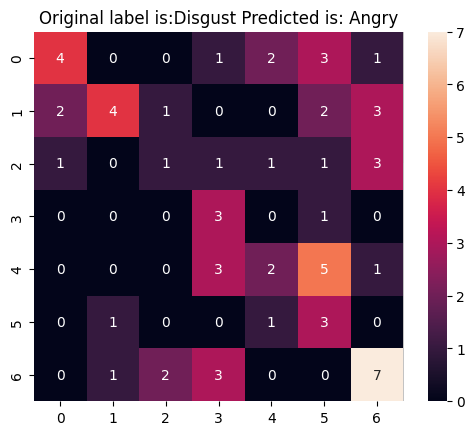

In [51]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [52]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.5293


In [53]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 37ms/step
Accuracy: 52.9296875
Angry 293/2100 acc: 56.3
Disgust 296/2100 acc: 40.2
Fear 292/2100 acc: 29.1
Happy 295/2100 acc: 74.9
Neutral 290/2100 acc: 51.0
Sad 291/2100 acc: 59.5
Surprise 291/2100 acc: 59.5


# Accuracy global and per class

In [54]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 52.9296875
Angry 293/2100 acc: 56.3
Disgust 296/2100 acc: 40.2
Fear 292/2100 acc: 29.1
Happy 295/2100 acc: 74.9
Neutral 290/2100 acc: 51.0
Sad 291/2100 acc: 59.5
Surprise 291/2100 acc: 59.5


              precision    recall  f1-score   support

       Angry       0.70      0.56      0.63       293
     Disgust       0.59      0.40      0.48       296
        Fear       0.59      0.29      0.39       292
       Happy       0.69      0.75      0.72       295
     Neutral       0.50      0.51      0.51       290
         Sad       0.33      0.59      0.42       291
    Surprise       0.54      0.59      0.57       291

    accuracy                           0.53      2048
   macro avg       0.56      0.53      0.53      2048
weighted avg       0.56      0.53      0.53      2048



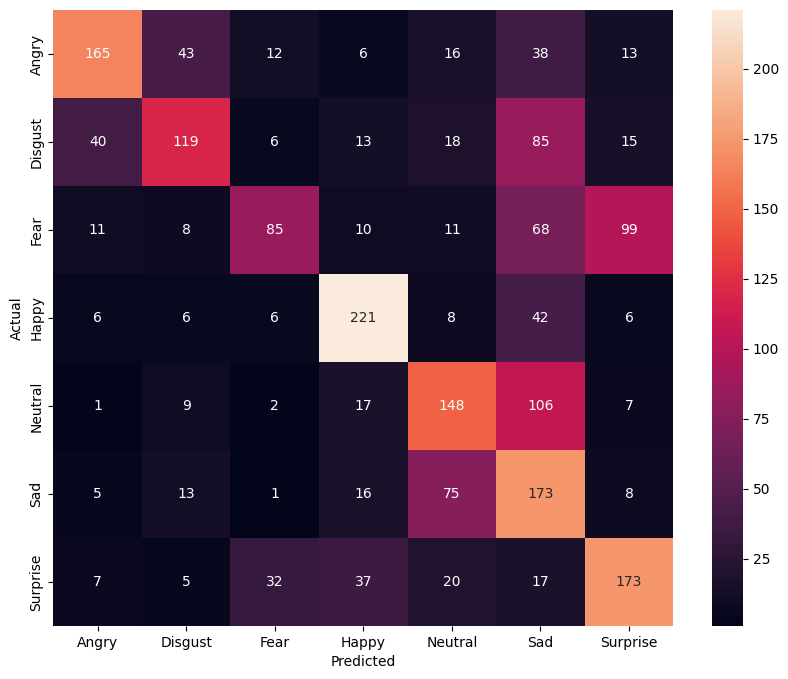

In [55]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test it with real images

In [56]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('VGG16_VGGFACE_100e_TF_FT_FER.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (224, 224))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 2s 2s/step
Predicted emotion class: sad, probability: 0.5729051828384399
1/1 [==============================] - 0s 169ms/step
Predicted emotion class: surprise, probability: 0.883309006690979
1/1 [==============================] - 0s 152ms/step
Predicted emotion class: fear, probability: 0.6678719520568848
1/1 [==============================] - 0s 160ms/step
Predicted emotion class: sad, probability: 0.973157525062561
1/1 [==============================] - 0s 163ms/step
Predicted emotion class: happy, probability: 0.9999674558639526
1/1 [==============================] - 0s 162ms/step
Predicted emotion class: angry, probability: 0.9997965693473816
1/1 [==============================] - 0s 161ms/step
Predicted emotion class: angry, probability: 0.996711015701294
1/1 [==============================] - 0s 167ms/step
Predicted emotion class: angry, probability: 0.5379007458686829
1/1 [==============================] - 0s 173ms/step
Predicted emotion c